<a href="https://colab.research.google.com/github/LukasBeckers/Transformer_Image_Completion/blob/main/Image_Completion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# Imports

from google.colab.patches import cv2_imshow
from tensorflow.keras import layers
from glob import glob, escape
from keras.layers import activation
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle as pk
import numpy as np
import shutil
import random
import time
import cv2
import os

print(tf.__version__)

2.11.0


In [6]:
# Checking if a GPU is available.

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18162001867036027407
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14401011712
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5799747419564491947
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


#Loading the Model
The next cell will load the model checkpoint from your Google-Drive and define all nessesary functions.

In [11]:
#@markdown # Downloading the MNIST Dataset 
#@markdown # And Loading the Model Checkpoint From Your Drive

batch_size = 500 #@param {type:"integer"}

mnist = tfds.load('MNIST', batch_size=batch_size)

train_ds = mnist['train']
test_ds = mnist['test']

def split_image(image, segment_width):
    '''
    This function crops the image, so that the width and the hight of the image 
    are devisible by the 'segment_width' parameter. 
    The cropped image is split into square-segments in the size of the 'segment_width'.

    :param image:           image (tf-tensor or np.array) of shape[higth, width, 1]
    :param segment_width:   Width of the segments-squares that the image will be split into

    :return:                tf-tensor of shape[hight//segment_width, width//segment_width, segment_width, segment_width, 1].
                            If the image width or hight is not devisable by the segment_width, it will be cropped.
    '''
    # Cropping the image
    image = image[:image.shape[0] // segment_width * segment_width]   # Cropping height
    image = image[:,:image.shape[1] // segment_width * segment_width] # Cropping width
    # Splitting the image.
    # First the width is split, then the hight of the image is split.
    image = tf.reshape(image, [image.shape[0],                        # height
                               image.shape[1]//segment_width,         # N_width_segments
                               segment_width,                         # segment_width
                               image.shape[2]                         # 1
                               ])
    image = tf.transpose(image, [1, 0, 2, 3])                         # Swapping height and N_width_segments
    image = tf.reshape(image, [image.shape[0],                        # N_width_segments
                               image.shape[1]//segment_width,         # N_height_segments
                               segment_width,                         # segment_width
                               segment_width,                         # segment_width
                               image.shape[3]                         # 1
                               ])
    image = tf.transpose(image, [1, 0, 2, 3, 4])                      # Swapping N_width_segments and N_height_segments
    # Output shape: [N_height_segments, N_width_segments, segment_width, segment_width, 1]
    return image

"""
The output of the transformer-model will also have the shape of a split-image.
For this reason, a function to reverse the split process is needed.
This function will be able to create normal (non-split) images from split-images.
"""

def unsplit_image(image):
    '''
    This function reverses the split_image function (except the cropping).

    :param image:           split RGB-image tf-tensor of shape[N_height_segments, N_width_segments, segment_width, segment_width, RGB]

    :return:                RGB-image-batch tf-tensor of shape[N_images, heigth, width, RGB]
    '''
    image = tf.transpose(image, [1, 0, 2, 3, 4])                      # Swapping N_width_segments and N_height_segments
    image = tf.reshape(image, [image.shape[0],                        # N_width_segments
                               image.shape[1]*image.shape[2],         # N_hight_segments * segment_width = height
                               image.shape[3],                        # segment_width
                               image.shape[4]                         # RGB
                               ])
    image = tf.transpose(image, [1, 0, 2, 3])                         # Swapping height and N_width_segments
    image = tf.reshape(image, [image.shape[0],                        # height
                               image.shape[1]*image.shape[2],         # N_width_segments * segment_width = width
                               image.shape[3]                         # RGB
                               ])
    return image


def split_image_batch(batch, segment_width):
    """
    A version of the split_image function that can be applied to batches of images.

    :param batch:   tf.tensor: Batch of images, shape=[batch_size, hight, widht, RGB]
    :param segment_width: int: Width of the segments-squares that the image will be split into.

    :return:        tf-tensor: Batch of split images, shape = [batch_size, 
                                                               hight//segment_width, 
                                                               width//segment_width, 
                                                               segment_width,
                                                               segment_width,
                                                               RGB].
                               If the image width or hight is not devisable by the segment_width, it will be cropped.
    """
 
    # Cropping the images.
    batch = batch[:,:batch.shape[1] // segment_width * segment_width]   # Cropping height
    batch = batch[:,:,:batch.shape[2] // segment_width * segment_width] # Cropping width
    # Splitting the images.
    # First the width is split, then the hight of the image is split.
    batch = tf.reshape(batch, [batch.shape[0],                          # batch-size
                               batch.shape[1],                          # height
                               batch.shape[2]//segment_width,           # N_width_segments
                               segment_width,                           # segment_width
                               batch.shape[3]                           # RGB
                               ])
    batch = tf.transpose(batch, [0, 2, 1, 3, 4])                        # Swapping height and N_width_segments
    batch = tf.reshape(batch, [batch.shape[0],                          # batch-size
                               batch.shape[1],                          # N_width_segments
                               batch.shape[2]//segment_width,           # N_height_segments
                               segment_width,                           # segment_width
                               segment_width,                           # segment_width
                               batch.shape[4]                           # RGB
                               ])
    batch = tf.transpose(batch, [0, 2, 1, 3, 4, 5])                     # Swapping N_width_segments and N_height_segments
    # Output shape: [batch_size, N_height_segments, N_width_segments, segment_width, segment_width, RGB]
    return batch


def unsplit_batch(batch):
    '''
    This reverses the 'split_image_batch' function, excep for the cropping.
    It will be used to unsplit the output of the model.
    :param batch:           split-images batch tf-tensor of shape[N_images,
                                                                  N_hight_segments,
                                                                  N_width_segments,
                                                                  segment_width,
                                                                  segment_width, 
                                                                  RGB]
    :return:                RGB-image batch tf-tensor of shape[N_images, hight, width, RGB]
    '''
    batch = tf.transpose(batch, [0, 2, 1, 3, 4])                           # Swapping N_width_segments and N_hight_segments
    batch = tf.reshape(batch, [-1,                                         # N_images
                               tf.shape(batch)[1],                         # N_width_segments
                               tf.shape(batch)[2]*tf.shape(batch)[3],      # N_hight_segments * segment_width = hight
                               tf.shape(batch)[4],                         # segment_width
                               ])  	                                   
    batch = tf.transpose(batch, [0, 2, 1, 3])                              # Swapping height and N_width_segments
    batch = tf.reshape(batch, [-1,                                         # N_images
                               tf.shape(batch)[1],                         # hight
                               tf.shape(batch)[2]*tf.shape(batch)[3],      # N_width_segments * segment_width = width
                               ])
    return batch


def flatten_batch(batch):
    '''
    This function can be used inside the call-method of a keras model.
    This function will be used to flatten the image-batches for the transformer-layers in the model.
    :param images: (tf.tensor): Batch of split-images.
                                Shape for batch of images: [batch_size, n_hight_segments, n_width_segments, segment_width, segment_width, RGB]

    :return:       (tf.tensor): flattend batch of images.
                                Shape: [batch_size, n_hight_segments * n_width_segments, ?]
    '''
    out = tf.reshape(batch, [-1, tf.shape(batch)[1]*tf.shape(batch)[2], tf.shape(batch)[3]*tf.shape(batch)[4]*tf.shape(batch)[5]])
    return out

def unflatten_batch(images, n_hight_segments, n_width_segments, segment_width):
    '''
    This function can be used inside the call-method of a keras model.
    This function reverses the flatten operation done to a batch of images by the 'flatten_batch' function
    :param images: (tf.tensor): Batch of flattend RGB-images.
                                Shape: [batch_size, n_hight_segments * n_width_segments, ?]

    :return:       (tf.tensor): Batch of split RGB-images.
                                Shape: [batch_size, n_hight_segments, n_width_segments, segment_width, segment_width, RGB]
    '''
    out = tf.reshape(images, [-1, n_hight_segments, n_width_segments, segment_width, segment_width])
    return out

def transform_dataset(dataset, segment_width):
    def extract_images(batch):
        batch = tf.cast(batch['image'], tf.float32)
        # Normalizing between 0 and 1
        batch /= 255
        return batch

    def split_image_wrapper(batch):
        image = tf.numpy_function(split_image_batch, [batch, segment_width], tf.float32)
        return image

    def remove_last_element(batch):
        """
        The model will be trained to predict the next image segment of the image
        autoregressively. For this reason the last element of the split- and  
        flattend-images is removed. 
        In the call function of the model, a start token will be added to the 
        start of the image-sequence. This way, the input and target sequence are 
        shifted for on image-segment to each other.
        """
        inputs = batch[:,:-1]
        targets = batch
        return inputs, targets
    dataset = dataset.map(extract_images)
    dataset = dataset.map(split_image_wrapper)
    dataset = dataset.map(flatten_batch)
    dataset = dataset.map(remove_last_element)
    return dataset

segment_width = 4
train_ds_processed = transform_dataset(train_ds, segment_width)
test_ds_processed = transform_dataset(test_ds, segment_width)

class MultiHeadSelfAttention(tf.keras.Model):
    def __init__(self, model_dim, n_heads, dropout_rate=0.1):
        '''
        :param model_dim:       (int): Model dimension.
        :param n_heads:         (int): Number of attention heads
        :param dropout_rate:    (int): dropout_rate used in the Multiheaded attention layer
        '''
        super(MultiHeadSelfAttention, self).__init__()
        assert model_dim % n_heads == 0, f'The dimension of the model must be devisible by the number of used attention heads.\nargs:\n\tnumber of heads: {n_heads}\n\tmodel dimension: {model_dim}\nrest:\t´{model_dim%n_heads}'

        self.model_dim = model_dim
        self.n_heads = n_heads
        # Calculating the head dimension
        self.head_dim = int(model_dim/n_heads)
        # Creating a key, query and value layer for all attention heads
        self.key_layer = layers.Dense(self.head_dim, use_bias=False)
        self.query_layer = layers.Dense(self.head_dim, use_bias=False)
        self.value_layer = layers.Dense(self.head_dim, use_bias=False)
        # Creating a dropout-layer for the linear layers
        self.dropout = layers.Dropout(dropout_rate)
        # Softmax function for the attention matrix
        self.softmax = activation.Softmax(axis=3)

    def call(self, inputs):
        '''
        :param inputs: (tf.tensor): Input Tensor of shape [Batch_size, n_segments, model_dim]
                                    If the multi-head attention object is part of the first transformer layer,
                                    the input is the split and flattended batch of  images with both the width and
                                    hight embeddings allready added.

        :return:       (tf.tensor). Output of the multi-head attention object. Shape [Batch_size, n_segments, model_dim]
        '''
        def create_mask(n_segments):
            """
            This function creates a boolean mask for the attention-matrix.
            This mask will be a simple mask which prevents forward attention.

            Example for n_segments=4:

            [[[[True], [False], [False], [False]],    
              [[True], [True],  [False], [False]],
              [[True], [True],  [True],  [False]],
              [[True], [True],  [True],  [True]]
            ]]

            :param n_segments: (int): Number of image-segments of the input of the 
                               'call'-function.

            :return:           (tf-tensor, dtype=bool): Attention maks of shape:[1, 1, n_segments, n_segments]
            """
            mask = tf.linalg.band_part(tf.ones((1, 1, n_segments, n_segments), tf.bool), -1, 0)
            return mask

        # splitting the inputs into the correct number of n_heads_g
        # Reshaping to [Batch_size, n_segments, n_heads, head_dimensions]
        inputs = tf.reshape(inputs, [-1, tf.shape(inputs)[1], self.n_heads, self.head_dim])
        keys = self.key_layer(self.dropout(inputs))
        queries = self.query_layer(self.dropout(inputs))
        values = self.value_layer(self.dropout(inputs))
        # computing the attention-matrix
        # Einsum Function: 'keys'[Batch_size, n_segments, n_heads, head_dimensions],
        # 'queries'[Batch_size, n_segments, n_heads, head_dimensions] -> 'attention_-matrix'[Batch_size, n_heads,
        # n_segments_queries, n_segments_keys]
        attention_matrix = tf.einsum('nqhd, nkhd->nhqk', queries, keys)
        # Scaling the attention matrix by the square-root of the model-dimension.
        attention_matrix /= self.head_dim**0.5
        # Creating the attention-mask.
        attention_mask = create_mask(tf.shape(inputs)[1])
        # Applying the softmax function to the attention matrix.
        attention_matrix = self.softmax(attention_matrix, attention_mask)
        # Using the scaled attention_matrix and applying it to the value tensor.
        # Einsum Function: 'attention_matrix'[Batch_size, n_heads, n_segments_queries, n_segments_keys],
        # 'values'[Batch_size, n_segments_values, n_heads, head_dimensions] -> 'output'[Batch_size, n_segments,
        # n_heads, head_dimensions]
        output = tf.einsum('nhql, nlhd->nqhd', attention_matrix, values)
        #reshaping the output to [Batch_size, n_segments, model_dimensions]
        output = tf.reshape(output, [-1, tf.shape(output)[1], self.model_dim])
        return output

class TransformerLayer(tf.keras.Model):
    def __init__(self, model_dim, n_heads, linear_expansion, dropout_rate=0.1):
        '''
        :param model_dim:        (int): Dimensions of the model.
        :param n_heads:          (int): Number of attention heads
        :param linear_expansion: (int): During linear expansion, the output will be expanded to
                                        linerar_expansion * model_dim
        :param dropout_rate:     (int): dropout_rate used in the transformer-layer
        '''
        super(TransformerLayer, self).__init__()
        self.model_dim = model_dim
        self.n_heads = n_heads
        self.linear_expansion = linear_expansion
        self.dropout_rate = dropout_rate
        # defining the layers
        self.multi_head_attention = MultiHeadSelfAttention(model_dim = self.model_dim,
                                                           n_heads = self.n_heads,
                                                           dropout_rate=self.dropout_rate)
        self.input_layer = layers.InputLayer(input_shape=(self.model_dim, ))
        self.layer_1 = layers.Dense(self.model_dim*self.linear_expansion, activation='relu')
        self.layer_2 = layers.Dense(self.model_dim, activation='relu')
        self.dropout = layers.Dropout(dropout_rate)
        self.norm1 = layers.BatchNormalization()
        self.norm2 = layers.BatchNormalization()

    def call(self, inputs):
        '''
        :param inputs: (tf.tensor): Input Tensor of shape [Batch_size, n_segments, model_dim]
                                    If the multi-head attention object is part of the first transformer layer,
                                    the input is the split and flattended batch of  images with both the width and
                                    hight embeddings allready added.
        :return:       (tf.tensor). Output of the transformer-layer. Shape [Batch_size, n_segments, model_dim]
        '''
        skip_0 = inputs
        out = self.multi_head_attention(inputs)
        # Skip connection to counteract deminishing gradients
        out = self.norm1(out + skip_0)
        skip_1 = out
        out = self.layer_1(self.dropout(out))
        out = self.layer_2(self.dropout(out))
        # Skip connection to counteract deminishing gradients
        out = self.norm2(out + skip_1)
        return out

class PositionalEncoding():
    '''
    Creates an PositionalEncoding object, with defined maximum sequence length and encoding dimension.
    '''
    def __init__(self, max_length, encoding_dimension):
        '''
        :param max_length:           Maximum position that can be meening-fully encoded.

        :param encoding_dimension:   Dimension of the encoded positions.
                                     This parameter should match the encoding dimension of the transformer model, that is used.
        '''
        self.max_length = max_length                    # Highest encoded position.
        self.encoding_dimension = encoding_dimension    # Output dimension of the positional encoding vector

    def __call__(self, positions):
        '''
        :param positions: An array of positions to encode.
                          All positions should be in form of ints.
                          Example: positions=[0, 1, 3] would return a tensor of shape [3, encoding_dimension]
                          with the encoded positions 0, 1, 3.
        :return:          Tensorflow Tensor of shape [N_positons, encoding_dimension]
        '''
        encoded_positions = np.full([len(positions), self.encoding_dimension],  # 2D np.array of shape [N_positions, encoding_dimensions]
                                    tf.range(self.encoding_dimension),          # filled with numbers from 0...(encoding_dimension-1)
                                    dtype=np.float32)
        encoded_positions = encoded_positions//2                                # all elements of array floor-devided by two
        encoded_positions = self.max_length**(-2
                                              *encoded_positions
                                              /self.encoding_dimension)
        positions_array = np.full([self.encoding_dimension,
                                   len(positions)],
                                  positions)

        positions_array = np.swapaxes(positions_array, 0, 1)
        encoded_positions = encoded_positions * positions_array
        encoded_positions[::2] += np.pi/2                                       # Adding Pi/2 to every odd row, so that sin = cos for odd rows.
        encoded_positions = np.sin(encoded_positions)                           # Calling the sinus function on each element in the array.
        encoded_positions = tf.convert_to_tensor(encoded_positions,             # Converting output to tensorflow tensor.
                                                 dtype=tf.float32)
        return encoded_positions

class TransformerModel(tf.keras.Model):
    def __init__(self, model_dim, image_dim, n_heads, linear_expansion, n_layers, segment_width, dropout_rate=0.1, max_length=100):
        '''
        :param model_dim:        (int): Dimensions of the model.
        :param image_dim:        (int): Number of pixels per image-segment.
        :param linear_expansion: (int): During linear expansion in the transformer-layers,
                                        the output will be expanded to linerar_expansion * model_dim
        :param n_heads:          (int): Number of attention heads
        :param n_layers:         (int): Number of layers the model will be comprised of.
        :param segment_width     (int): Width of the segments the image will be split into.
        :param dropout_rate:     (int): Dropout-rate used in the transformer-layer
        '''
        super(TransformerModel, self).__init__()
        self.model_dim = model_dim
        self.image_dim = image_dim
        self.n_heads = n_heads
        self.linear_expansion = linear_expansion
        self.n_layers = n_layers
        self.segment_width = segment_width
        self.dropout_rate = dropout_rate
        self.max_length=max_length

        # creating the positional encoder.
        self.pos_enc = PositionalEncoding(self.max_length, self.model_dim)

        self.norm1 = layers.BatchNormalization()
        # Defining the layers
        self.image_encoding = layers.Dense(self.model_dim)
        self.transformer_layers = []
        for _ in range(self.n_layers):
            self.transformer_layers.append(TransformerLayer(self.model_dim,
                                                self.n_heads,
                                                self.linear_expansion,
                                                self.dropout_rate))

        self.norm_out = layers.BatchNormalization()
        # The output of the model should be a RGB-image of the same size as the input.
        self.output_layer = layers.Dense(self.image_dim, activation='sigmoid')
        # Defining a learnable 'start_sequence_token' 
        self.start_sequence_token = tf.random.uniform([1, 1, self.model_dim])
        

    def call(self, inputs):
        '''
        :param inputs:  (tf.tensor): Batch of images
        :return:       (tf.tensor): Batch of predicted segmentation masks. Shape=[batch_size, N_segments_hight, N_segments_width]
        '''
        def add_start_token(inputs):
            """
            This function adds the learnable 'start_sequence_token' to the start 
            of the image-segment seqences.           
            :param inputs:  (tf.tensor): Input of the 'call'-function, flattened
                                         by the 'flatten_batch' function.
                                         shape=[batch_size, n_segments, N_pixels_per_segment]
                                         
            """
            batch_size = inputs.shape[0]
            start_sequence_token = tf.concat([self.start_sequence_token for _ in range(batch_size)], axis=0)
            inputs = tf.concat([start_sequence_token, inputs], axis=1)
            return inputs

        def add_positions(inputs, strength=0.4):
            """
            This function encodes the positions of the image segments, after the 
            'flatten_batch' function.
            :param inputs:   (tf.tensor): Inputs of the call function after flatten batch and image encoding call.
            :param strength: (float): Factor by which the positional encodings are scaled before they are added to the image
            """
            batch_size = inputs.shape[0]
            positions = self.positional_encoding([i for i in range(inputs.shape[1])])
            positions = tf.stack([positions for _ in range(batch_size)])
            positions *= strength
            return inputs + positions

        skip_1 = self.image_encoding(inputs)
        n_segments = tf.shape(skip_1)[1]
        inputs = tf.numpy_function(add_start_token, [skip_1], tf.float32)
        # See reshaping above. Soely for the graph.
        inputs = tf.reshape(inputs, [-1, n_segments+1, self.model_dim])  # n_segments + 1 due to the added start-token

        # Adding skip-connection to allow a gradient flow arround the numpy-functions.
        slice_1 = inputs[:,1:] 
        slice_2 = inputs[:,:1]
        slice_1 += skip_1
        inputs = tf.concat([slice_2, slice_1], axis=1)
        inputs = self.norm1(inputs)

        for layer in self.transformer_layers:
           inputs = layer(inputs)

        inputs = self.norm_out(inputs)
        inputs = self.output_layer(inputs)
        output = inputs
        return output

# @markdown ##Change these parameters to the parameters of your custom model (if you trained a custom model) 

model_dimension = 400 # @param {type:"integer"}
segment_width = 4 # @param {type:"integer"}
image_dim = segment_width**2
n_heads = 2 # @param {type:"integer"}
linear_expansion = 2 # @param {type:"integer"}
n_layers = 3 # @param {type:"integer"}
dropout_rate = 0.1 # @param {type:"number"}
max_length = 100 # @param {type:"integer"}


model = TransformerModel(model_dimension,
                         image_dim,
                         n_heads,
                         linear_expansion,
                         n_layers,
                         segment_width,
                         dropout_rate, 
                         max_length)    

# Connecting the notebook to your google-drive

from google.colab import drive
drive.mount('/content/drive')
#@markdown ## Path to the model-checkpoint on your drive
model_path = "/content/drive/MyDrive/Colab Notebooks/Transformer_Image_Completion/model_checkpoints/working 1/Weights" #@param {type:"string"}
_ = model.load_weights(model_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
def predict_missing_part(cut_images, segments_to_predict):
    '''
    :param cut_images:    (tf.tensor): Batch of images transformed by the 'transform_dataset'
                                       function. Shape: [batch_size, n_segments, segment_widht**2]
    :param segments_to_predict: (int): Number of segments the model needs to predict to fill the image.

    return:  (tf.tensor): Batch of completed images.
    '''

    for i in range(segments_to_predict):
        predictions = model.predict(cut_images, verbose=0)
        cut_images = tf.concat([cut_images, predictions[:, -1:]], axis=1)
        print(f'Predicted segment {i}')
    return cut_images

Predicted segment 0
Predicted segment 1
Predicted segment 2
Predicted segment 3
Predicted segment 4
Predicted segment 5
Predicted segment 6
Predicted segment 7
Predicted segment 8
Predicted segment 9
Predicted segment 10
Predicted segment 11
Predicted segment 12
Predicted segment 13
Predicted segment 14
Predicted segment 15
Predicted segment 16
Predicted segment 17
Predicted segment 18
Predicted segment 19
Predicted segment 20
(500, 49, 16)


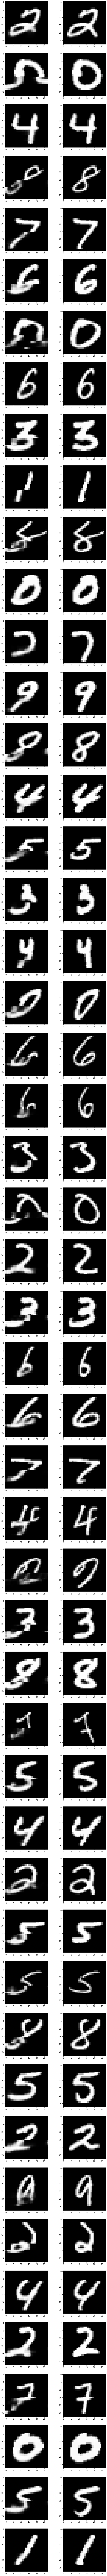

In [16]:
for test_batch in test_ds_processed:
    break

starting_segments = 28

cut_test_images = test_batch[0][:,:starting_segments]

completed_images = predict_missing_part(cut_test_images, 49-starting_segments)
print(completed_images.shape)

completed_images= unflatten_batch(completed_images, 7, 7, 4)
completed_images = unsplit_batch(completed_images)
targ = unflatten_batch(test_batch[1], 7, 7, 4)
unsplit_targ = unsplit_batch(targ)

n = 50
fig, axs = plt.subplots(n, 2, figsize=[10, 5*n])
for i in range(n):
    axs[i, 0].imshow(completed_images[i], cmap='gray')
    axs[i, 1].imshow(unsplit_targ[i], cmap='gray')
plt.show()

16/16 [==============================] - 3s 21ms/step


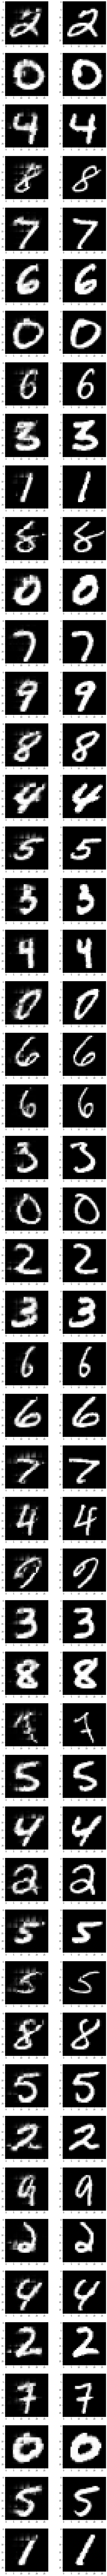

In [12]:
# Printing the model's predictions.

for test_batch in test_ds_processed:
    break

out = model.predict(test_batch[0])
out = unflatten_batch(out, 7, 7, 4)
unsplit_out = unsplit_batch(out)
targ = unflatten_batch(test_batch[1], 7, 7, 4)
unsplit_targ = unsplit_batch(targ)

n = 50
fig, axs = plt.subplots(n, 2, figsize=[10, 5*n])
for i in range(n):
    axs[i, 0].imshow(unsplit_out[i], cmap='gray')
    axs[i, 1].imshow(unsplit_targ[i], cmap='gray')
plt.show()

In [ ]:
def predict_missing_part(cut_images, segments_to_predict):
    '''
    :param cut_images:    (tf.tensor): Batch of images transformed by the 'transform_dataset'
                                       function. Shape: [batch_size, n_segments, segment_widht**2]
    :param segments_to_predict: (int): Number of segments the model needs to predict to fill the image.

    return:  (tf.tensor): Batch of completed images.
    '''

    for i in range(segments_to_predict):
        predictions = model.predict(cut_images, verbose=0)
        cut_images = tf.concat([cut_images, predictions[:, -1:]], axis=1)
        print(f'Predicted segment {i}')
    return cut_images



In [ ]:
for test_batch in test_ds_processed:
    break

starting_segments = 35

cut_test_images = test_batch[0][:,:starting_segments]

completed_images = predict_missing_part(cut_test_images, 49-starting_segments)
print(completed_images.shape)

completed_images= unflatten_batch(completed_images, 7, 7, 4)
completed_images = unsplit_batch(completed_images)
targ = unflatten_batch(test_batch[1], 7, 7, 4)
unsplit_targ = unsplit_batch(targ)

n = 50
fig, axs = plt.subplots(n, 2, figsize=[10, 5*n])
for i in range(n):
    axs[i, 0].imshow(completed_images[i], cmap='gray')
    axs[i, 1].imshow(unsplit_targ[i], cmap='gray')
plt.show()

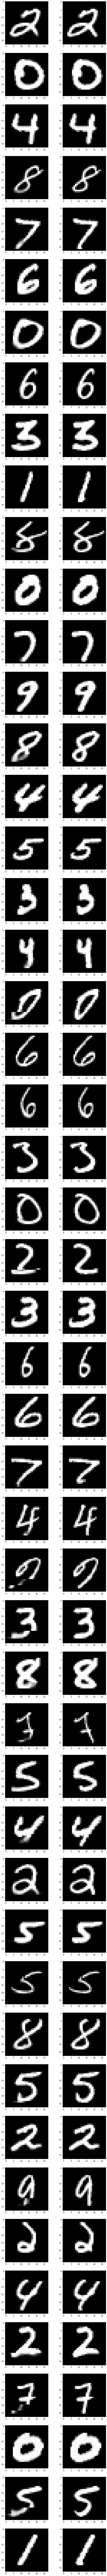

In [ ]:
completed_images= unflatten_batch(completed_images, 7, 7, 4)
completed_images = unsplit_batch(completed_images)
targ = unflatten_batch(test_batch[1], 7, 7, 4)
unsplit_targ = unsplit_batch(targ)

n = 50
fig, axs = plt.subplots(n, 2, figsize=[10, 5*n])
for i in range(n):
    axs[i, 0].imshow(completed_images[i], cmap='gray')
    axs[i, 1].imshow(unsplit_targ[i], cmap='gray')
plt.show()